<h1> Neural Network </h1>

> After seeing what we thought was subpar performance from our knn and decicion tree models we explored the possibility of using a neural network. This repository outlines the neural network we trained and ultimately ended up discarding. It is important to note that the training was done utilizing Google Clouds Vertex AI free trial in order to access increased processing power (up to 16 CPU's in parallel), and any output seen here was copy pasted from that notebook.

> We begin by importing the required libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform

> Now we use code from our knn and decision tree models to clean the data and encode our categorical variables.

In [ ]:
#Reused code from knn and tree models to clean data
df = pd.read_csv("train.csv")
print("initial size of this DF: ")
print(df.shape)

df.columns= df.columns.str.replace(" ","_").str.lower()
df = df.dropna()
df = df.drop_duplicates()

X = df.drop(['class', 'artist_name', 'track_name'], axis=1)
y = df['class']

# Encoding categorical data
X = pd.get_dummies(X)

> Following data cleaning, we split our data into a training and test set and create a parameter distribution in order to do a randomized grid search. We also normalize our data to reduce the impact of outliers. We decided a randomized grid search would be better than exhaustive grid search due to the amount of time required to train each model.

In [ ]:
# Split dataset into training set and test set with 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Normalize features using RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Parameter distribution for randomized search
param_distribution = {
    'hidden_layer_sizes': [(x, x, x) for x in np.arange(10, 110, 10)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': uniform(0.0001, 0.05),
    'learning_rate': ['constant', 'adaptive'],
}

> Now for the good stuff, we begin our randomized search, iterating over each model up to 3000 times in order to train it. Every available CPU is utilized from the n_jobs=-1 parameter. The amount of models to be fit is 250, from 5 folds over 50 candidates. Then we print the best parameters and predict on our test data, generating a confusion matrix along with precision, f1, and recall scores.

In [ ]:
# Create the randomized search model
random_search = RandomizedSearchCV(estimator=MLPClassifier(max_iter=3000), param_distributions=param_distribution, n_iter=50, cv=5, n_jobs=-1, verbose=3)

# Fit the randomized search model to the data
random_search.fit(X_train, y_train)

# Get the optimal parameters
print(random_search.best_params_)

# Predict for test data
predictions = random_search.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

{'activation': 'tanh', 'alpha': 0.000874834824410381, 'hidden_layer_sizes': (20, 20, 20), 'learning_rate': 'adaptive', 'solver': 'sgd'}
[[ 67   0   0   6   8   0   0   5   0   0   2]
 [  0   6   8   0   0   7  53   0  10  12 119]
 [  0   0  88   0   0   4  25   0   3   8  64]
 [ 10   0   0  39   3   0   0   1   0   1   1]
 [  8   0   0   6  13   0   0   0   0   2   3]
 [  0   0   8   0   0  46  16   0   0  21  14]
 [  0   3  27   0   0  11 126   0  19  25 171]
 [  7   0   0   3   0   0   0  78   0   0   0]
 [  0   0   2   0   0   0  20   0 173   1 127]
 [  3   1  10   0   1  16  28   0   1  87  63]
 [  1   2  38   2   9   5  73   0  68  37 438]]
 
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        88
           1       0.50      0.03      0.05       215
           2       0.49      0.46      0.47       192
           3       0.70      0.71      0.70        55
           4       0.38      0.41      0.39        32
           5       0.52      0.44      0.47       105
           6       0.37      0.33      0.35       382
           7       0.93      0.89      0.91        88
           8       0.63      0.54      0.58       323
           9       0.45      0.41      0.43       210
          10       0.44      0.65      0.52       673

        accuracy                           0.49      2363
       macro avg       0.55      0.51      0.51      2363
    weighted avg       0.50      0.49      0.47      2363

> The confusion matrix is basically unreadable, so let's make it more understandable using seaborn and matplot.

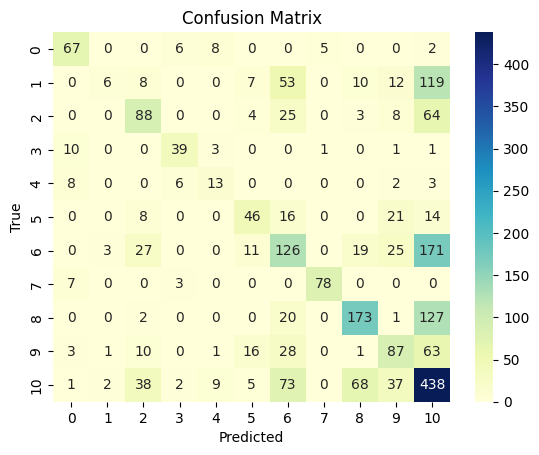

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_matrix = np.array([[ 67,   0,   0,   6,   8,   0,   0,   5,   0,   0,   2],
 [  0,   6,   8,   0,   0,   7,  53,   0,  10,  12, 119],
 [  0,   0,  88,   0,   0,   4,  25,   0,   3,   8,  64],
 [ 10,   0,   0,  39,   3,   0,   0,   1,   0,   1,   1],
 [  8,   0,   0,   6,  13,   0,   0,   0,   0,   2,   3],
 [  0,   0,   8,   0,   0,  46,  16,   0,   0,  21,  14],
 [  0,   3,  27,   0,   0,  11, 126,   0,  19,  25, 171],
 [  7,   0,   0,   3,   0,   0,   0,  78,   0,   0,   0],
 [  0,   0,   2,   0,   0,   0,  20,   0, 173,   1, 127],
 [  3,   1,  10,   0,   1,  16,  28,   0,   1,  87,  63],
 [  1,   2,  38,   2,   9,   5,  73,   0,  68,  37, 438]])

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<h1> Discussion </h1>

> Although an interesting endeavor, our network did not produce results that were better than our other models. More time or processing power may have yielded better results. It may also be that this is an intractable problem due to the nature of music classification. Many songs fit into multiple genres, and classif